# XMM-LSS master catalogue
## Preparation of HST CANDELS-3D data

The catalogue comes from `dmu0_CANDELS-3D-HST`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The kron magnitude, there doesn't appear to be aperture magnitudes. This may mean the survey is unusable.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "candels_ra"
DEC_COL = "candels_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'ID': "candels_id",
        'RAJ2000': "candels_ra",
        'DEJ2000': "candels_dec",
        'S/G':  "candels_stellarity",
        'F140Wap': "f_ap_candels_f140w",
        'e_F140Wap': "ferr_ap_candels_f140w",
        'F140W': "f_candels_f140w",
        'e_F140W': "ferr_candels_f140w",
        'F160Wap': "f_ap_candels_f160w",
        'e_F160Wap': "ferr_ap_candels_f160w",
        'F160W': "f_candels_f160w",
        'e_F160W': "ferr_candels_f160w",
        'F606W': "f_candels_f606w",
        'e_F606W': "ferr_candels_f606w",
        'F814W': "f_candels_f814w",
        'e_F814W': "ferr_candels_f814w",
        'F125W': "f_candels_f125w",
        'e_F125W': "ferr_candels_f125w"

    })


catalogue = Table.read("../../dmu0/dmu0_CANDELS-3D-HST/data/CANDELS-3D-HST_XMM-LSS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012 #Year of publication

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        #Calculate mags, errors including the fact that fluxes are in units of 0.3631 uJy
        mag, error = flux_to_mag(np.array(catalogue[col]) * 0.3631e-6, np.array(catalogue[errcol] * 0.3631e-6))
        
        
        # magnitudes are added
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        
        #Correct flux units to uJy
        catalogue[col] = catalogue[col] * 0.3631
        catalogue[col].unit = u.microjansky
        catalogue[errcol] = catalogue[errcol] * 0.3631
        catalogue[errcol].unit = u.microjansky        

        if ('125' in col) or ('814' in col) or ('606' in col) :
            # We add nan filled aperture photometry for consistency
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="m_ap{}".format(col[1:])))
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="merr_ap{}".format(col[1:])))
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="f_ap{}".format(col[1:])))
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="ferr_ap{}".format(col[1:])))

        

        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,candels_id,candels_ra,candels_dec,candels_stellarity,f_ap_candels_f140w,ferr_ap_candels_f140w,f_candels_f140w,ferr_candels_f140w,f_ap_candels_f160w,ferr_ap_candels_f160w,f_candels_f160w,ferr_candels_f160w,f_candels_f606w,ferr_candels_f606w,f_candels_f814w,ferr_candels_f814w,f_candels_f125w,ferr_candels_f125w,m_ap_candels_f140w,merr_ap_candels_f140w,m_candels_f140w,merr_candels_f140w,flag_candels_f140w,m_ap_candels_f160w,merr_ap_candels_f160w,m_candels_f160w,merr_candels_f160w,flag_candels_f160w,m_candels_f606w,merr_candels_f606w,m_ap_candels_f606w,merr_ap_candels_f606w,f_ap_candels_f606w,ferr_ap_candels_f606w,flag_candels_f606w,m_candels_f814w,merr_candels_f814w,m_ap_candels_f814w,merr_ap_candels_f814w,f_ap_candels_f814w,ferr_ap_candels_f814w,flag_candels_f814w,m_candels_f125w,merr_candels_f125w,m_ap_candels_f125w,merr_ap_candels_f125w,f_ap_candels_f125w,ferr_ap_candels_f125w,flag_candels_f125w
,,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,34.44606781,-5.28545713,2,nan,nan,nan,nan,0.181746,0.0283218,0.260964,0.046662,0.232061,0.0186978,0.256861,0.0223085,0.184553,0.0413063,nan,nan,nan,nan,False,25.7513,0.169192,25.3586,0.194137,False,25.486,0.087481,nan,nan,nan,nan,False,25.3758,0.0942969,nan,nan,nan,nan,False,25.7347,0.243007,nan,nan,nan,nan,False
1,2,34.44749069,-5.28481579,0,nan,nan,nan,nan,5.06706,0.0272383,7.60331,0.0859022,0.215732,0.0193983,1.0059,0.0233462,5.52239,0.0378386,nan,nan,nan,nan,False,22.1381,0.00583644,21.6975,0.0122666,False,25.5652,0.0976274,nan,nan,nan,nan,False,23.8936,0.0251993,nan,nan,nan,nan,False,22.0447,0.00743932,nan,nan,nan,nan,False
2,3,34.43383026,-5.28518391,2,nan,nan,nan,nan,0.0387028,0.0245289,0.0465894,0.0295262,0.0506525,0.0156108,0.0854447,0.0185893,0.131918,0.0377769,nan,nan,nan,nan,False,27.4306,0.688112,27.2293,0.68809,False,27.1385,0.334617,nan,nan,nan,nan,False,26.5708,0.236212,nan,nan,nan,nan,False,26.0992,0.310919,nan,nan,nan,nan,False
3,4,34.43863678,-5.28336287,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
4,5,34.44387817,-5.28445578,0,nan,nan,nan,nan,0.737383,0.0220986,0.971619,0.0507214,0.112626,0.0169844,0.165697,0.0204483,0.659644,0.0285219,nan,nan,nan,nan,False,24.2308,0.0325384,23.9313,0.0566787,False,26.2709,0.163732,nan,nan,nan,nan,False,25.8517,0.133988,nan,nan,nan,nan,False,24.3517,0.0469454,nan,nan,nan,nan,False
5,6,34.43869019,-5.28433704,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
6,7,34.44271088,-5.284338,0,nan,nan,nan,nan,0.456017,0.0258407,0.629978,0.093284,0.289754,0.017801,0.299695,0.0214893,0.624024,0.0322701,nan,nan,nan,nan,False,24.7525,0.0615245,24.4017,0.16077,False,25.2449,0.066702,nan,nan,nan,nan,False,25.2083,0.0778516,nan,nan,nan,nan,False,24.412,0.0561467,nan,nan,nan,nan,False
7,8,34.43680954,-5.2842989,2,nan,nan,nan,nan,0.074726,0.019151,0.0551258,0.0540511,0.0413389,0.00957967,0.0552057,0.0114166,0.0953718,0.0159688,nan,nan,nan,nan,False,26.7163,0.278255,27.0466,1.06457,False,27.3591,0.251603,nan,nan,nan,nan,False,27.045,0.224531,nan,nan,nan,nan,False,26.4515,0.181792,nan,nan,nan,nan,False
8,9,34.43286133,-5.28434801,2,nan,nan,nan,nan,0.0703797,0.0197476,0.122321,0.038859,0.0910909,0.0226796,0.0386774,0.0267089,0.14711,0.0424754,nan,nan,nan,nan,False,26.7814,0.304642,26.1813,0.344917,False,26.5013,0.270324,nan,nan,nan,nan,False,27.4314,0.749761,nan,nan,nan,nan,False,25.9809,0.313487,nan,nan,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:

SORT_COLS = ['merr_candels_f140w', 
             'merr_candels_f160w', 
             'merr_candels_f606w', 
             'merr_candels_f814w',
             'merr_candels_f125w']
FLAG_NAME = 'candels_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 44102 sources.
The cleaned catalogue has 43863 sources (239 removed).
The cleaned catalogue has 236 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_XMM-LSS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

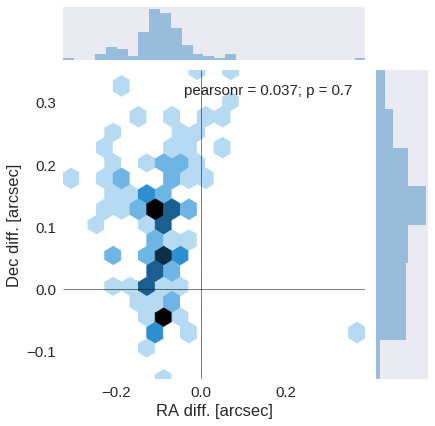

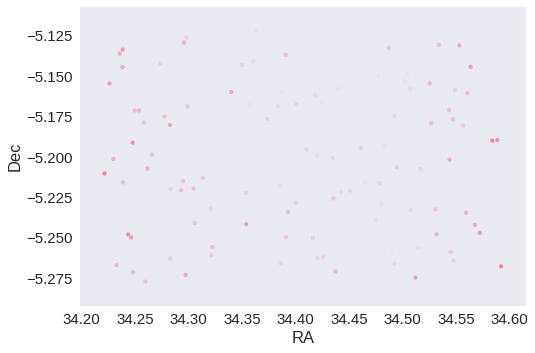

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.09405840634997276 arcsec
Dec correction: -0.10633781055542357 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

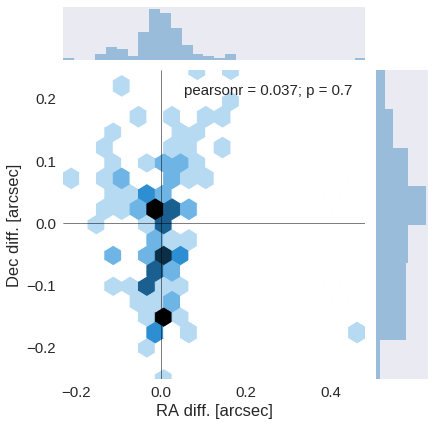

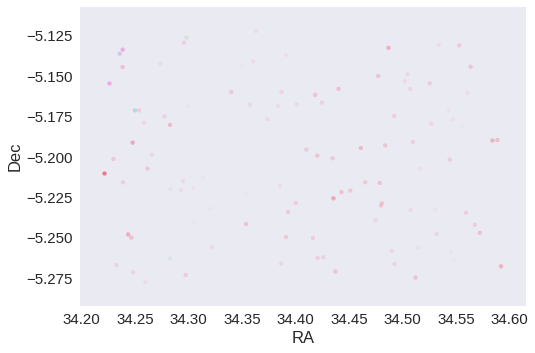

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "candels_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

127 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/CANDELS.fits".format(OUT_DIR), overwrite=True)